# Titanic Dataset

## Library Imports

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import shap
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, class_likelihood_ratios, RocCurveDisplay, DetCurveDisplay, PrecisionRecallDisplay
from sklearn.decomposition import PCA
from sklearn_pandas import DataFrameMapper
from shap import LinearExplainer, KernelExplainer, Explanation


## Data Cleaning and Feature Engineering

In [17]:
df_titanic_raw = pd.read_csv('titanic/train.csv')

In [18]:
df_titanic_raw = df_titanic_raw[(df_titanic_raw['Age'].notna())  & (df_titanic_raw['Fare'].notna()) & (df_titanic_raw['Embarked'].notna())]
df_titanic_raw = df_titanic_raw.drop(['PassengerId', 'Name', 'Ticket'],axis=1)

In [19]:
df_titanic_raw['Sex'].replace(['male', 'female'], [1, 0], inplace=True)
df_titanic_raw['Embarked'].replace(['C', 'Q', 'S'], [0, 1, 2], inplace=True)
df_titanic_raw = df_titanic_raw.reset_index(drop=True)
df_titanic_raw

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,NaN,2
1,1,1,0,38.0,1,0,71.2833,C85,0
2,1,3,0,26.0,0,0,7.9250,NaN,2
3,1,1,0,35.0,1,0,53.1000,C123,2
4,0,3,1,35.0,0,0,8.0500,NaN,2
...,...,...,...,...,...,...,...,...,...
707,0,3,0,39.0,0,5,29.1250,NaN,1
708,0,2,1,27.0,0,0,13.0000,NaN,2
709,1,1,0,19.0,0,0,30.0000,B42,2
710,1,1,1,26.0,0,0,30.0000,C148,0


In [20]:
df_titanic_raw['Deck'] = df_titanic_raw['Cabin'].map(lambda x: x[0] if x is not np.nan else 'U')
df_titanic_raw['Deck'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U'], [0, 1, 2, 3, 4, 5, 6, 7, 8], inplace=True)
df_titanic_raw['Age_Group'] = df_titanic_raw['Age'].map(lambda x: 0 if x < 18 else 1)
df_titanic_engineered = df_titanic_raw.drop(['Cabin'], axis=1)
df_titanic_engineered['Family_Size']=df_titanic_raw['SibSp'] + df_titanic_raw['Parch']
df_titanic_engineered['Fare_Per_Person']=df_titanic_engineered['Fare'] / (df_titanic_engineered['Family_Size'] + 1)
df_titanic = df_titanic_engineered

survived_labels = ['No', 'Yes']
age_labels = ['Child', 'Adult']
class_labels = ['1st', '2nd', '3rd']
embarked_labels = ['Cherbourg', 'Queenstown', 'Southampton']
sex_labels = ['Female', 'Male']
deck_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U']

df_titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Age_Group,Family_Size,Fare_Per_Person
0,0,3,1,22.0,1,0,7.2500,2,8,1,1,3.625000
1,1,1,0,38.0,1,0,71.2833,0,2,1,1,35.641650
2,1,3,0,26.0,0,0,7.9250,2,8,1,0,7.925000
3,1,1,0,35.0,1,0,53.1000,2,2,1,1,26.550000
4,0,3,1,35.0,0,0,8.0500,2,8,1,0,8.050000
...,...,...,...,...,...,...,...,...,...,...,...,...
707,0,3,0,39.0,0,5,29.1250,1,8,1,5,4.854167
708,0,2,1,27.0,0,0,13.0000,2,8,1,0,13.000000
709,1,1,0,19.0,0,0,30.0000,2,1,1,0,30.000000
710,1,1,1,26.0,0,0,30.0000,0,2,1,0,30.000000


<AxesSubplot: title={'center': 'Titanic Attributes Correlation Heatmap'}>

<Figure size 1000x500 with 0 Axes>

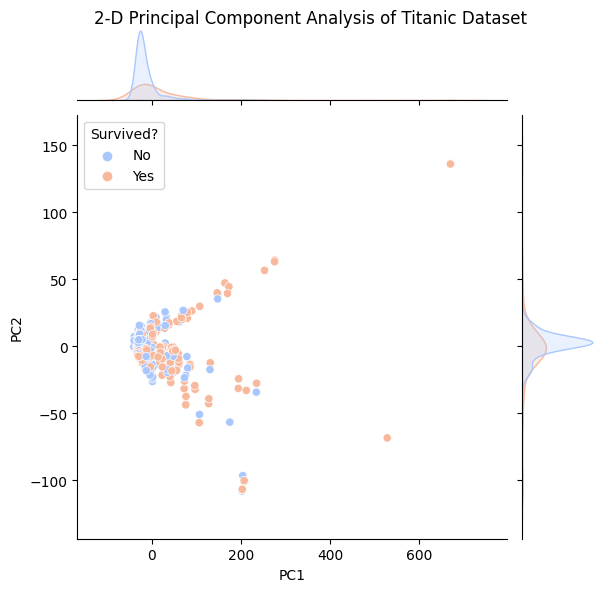

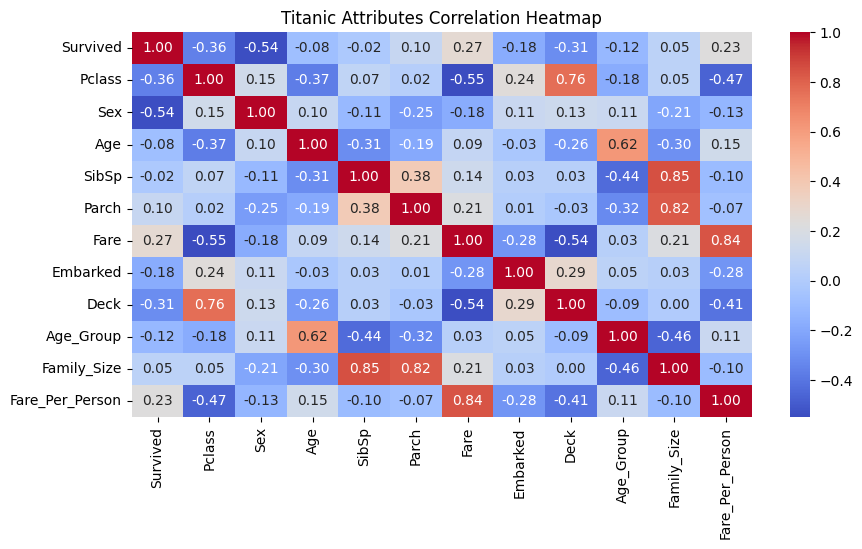

In [21]:
plt.figure(figsize=(10, 5))
pca = PCA(n_components=2)
pca.fit(df_titanic)
pca_df = pd.DataFrame(pca.transform(df_titanic), columns=['PC1', 'PC2'])
pca_df['Survived'] = df_titanic['Survived']

jg = sns.jointplot(data=pca_df, x="PC1", y="PC2", hue="Survived", palette='coolwarm')
jg.fig.subplots_adjust(top=0.95)
jg.fig.suptitle('2-D Principal Component Analysis of Titanic Dataset')
ax = plt.gca()
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=survived_labels, title='Survived?')


fig, ax0 = plt.subplots(figsize=(10, 5))

ax0.set_title('Titanic Attributes Correlation Heatmap')
corr = df_titanic.corr()
sns.heatmap(ax=ax0, data=round(corr, 2), annot=True, cmap="coolwarm", fmt='.2f')

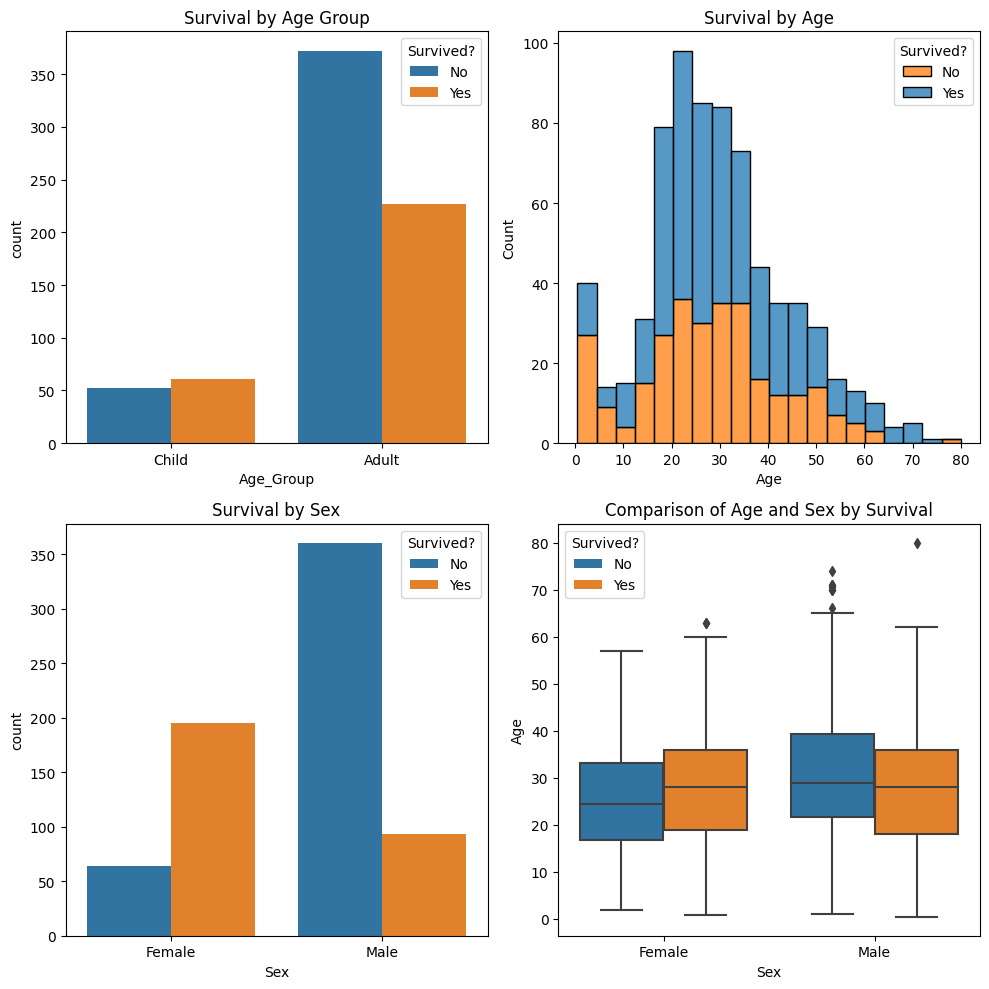

In [22]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(10, 10))

ax0.set_title('Survival by Age Group')
sns.countplot(ax=ax0, data=df_titanic, x="Age_Group", hue="Survived")
ax0.set_xticklabels(age_labels)
ax0.legend(survived_labels, title='Survived?')

ax1.set_title('Survival by Age')
sns.histplot(ax=ax1, data=df_titanic, x="Age", hue="Survived", multiple="stack")
ax1.legend(survived_labels, title='Survived?')

ax2.set_title('Survival by Sex')
sns.countplot(ax=ax2, data=df_titanic, x="Sex", hue="Survived")
ax2.set_xticklabels(sex_labels)
ax2.legend(survived_labels, title='Survived?')

ax3.set_title('Comparison of Age and Sex by Survival')
sns.boxplot(ax=ax3, data=df_titanic, x="Sex", y="Age", hue="Survived")
ax3.set_xticklabels(sex_labels)
handles, _ = ax2.get_legend_handles_labels()
ax3.legend(handles=handles, labels=survived_labels, title='Survived?')


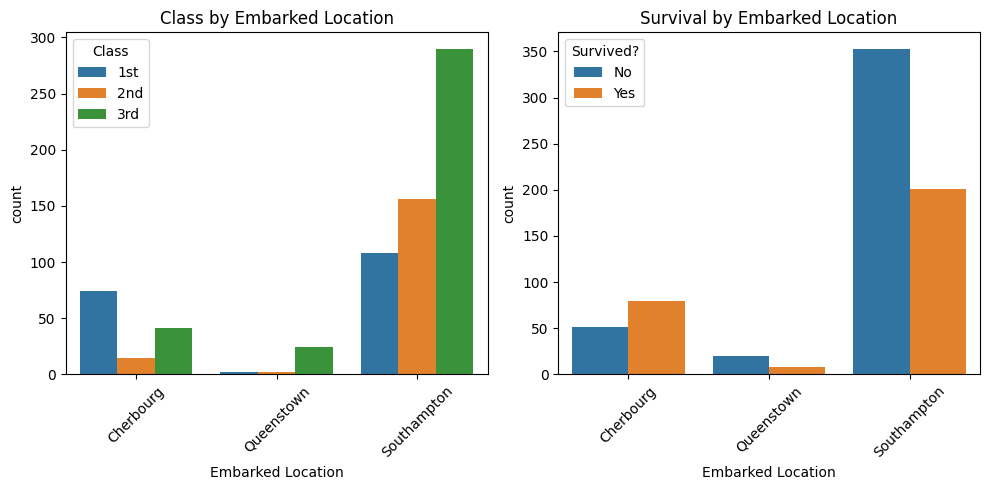

In [23]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, tight_layout=True, figsize=(10, 5))

ax0.set_title('Class by Embarked Location')
sns.countplot(ax=ax0, data=df_titanic, x="Embarked", hue="Pclass")
ax0.set_xticklabels(embarked_labels, rotation=45)
ax0.set_xlabel('Embarked Location')
ax0.legend(class_labels, title='Class')

ax1.set_title('Survival by Embarked Location')
sns.countplot(ax=ax1, data=df_titanic, x="Embarked", hue="Survived")
ax1.set_xticklabels(embarked_labels, rotation=45)
ax1.set_xlabel('Embarked Location')
ax1.legend(survived_labels, title='Survived?')

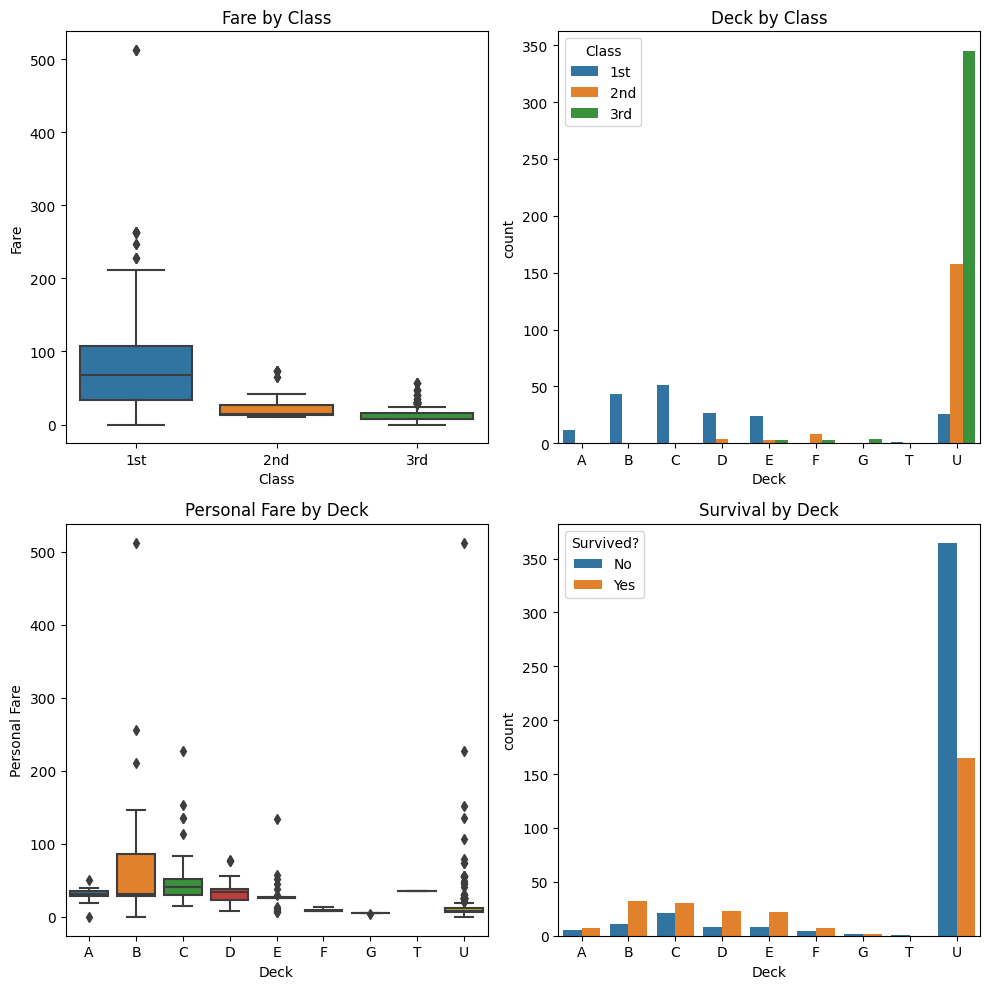

In [24]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(10, 10))

ax0.set_title('Fare by Class')
sns.boxplot(ax=ax0, data=df_titanic, x="Pclass", y="Fare")
ax0.set_xticklabels(class_labels)
ax0.set_xlabel('Class')
ax0.set_ylabel('Fare')

ax1.set_title('Deck by Class')
sns.countplot(ax=ax1, data=df_titanic, x="Deck", hue="Pclass", order=[0, 1, 2, 3, 4, 5, 6, 7, 8])
ax1.set_xticklabels(deck_labels)
ax1.set_xlabel('Deck')
ax1.legend(class_labels, title='Class')

ax2.set_title('Personal Fare by Deck')
sns.boxplot(ax=ax2, data=df_titanic, x="Deck", y="Fare_Per_Person", order=[0, 1, 2, 3, 4, 5, 6, 7, 8])
ax2.set_xticklabels(deck_labels)
ax2.set_xlabel('Deck')
ax2.set_ylabel('Personal Fare')

ax3.set_title('Survival by Deck')
sns.countplot(ax=ax3, data=df_titanic, x="Deck", hue="Survived", order=[0, 1, 2, 3, 4, 5, 6, 7, 8])
ax3.set_xticklabels(deck_labels)
ax3.set_xlabel('Deck')
ax3.legend(survived_labels, title='Survived?')

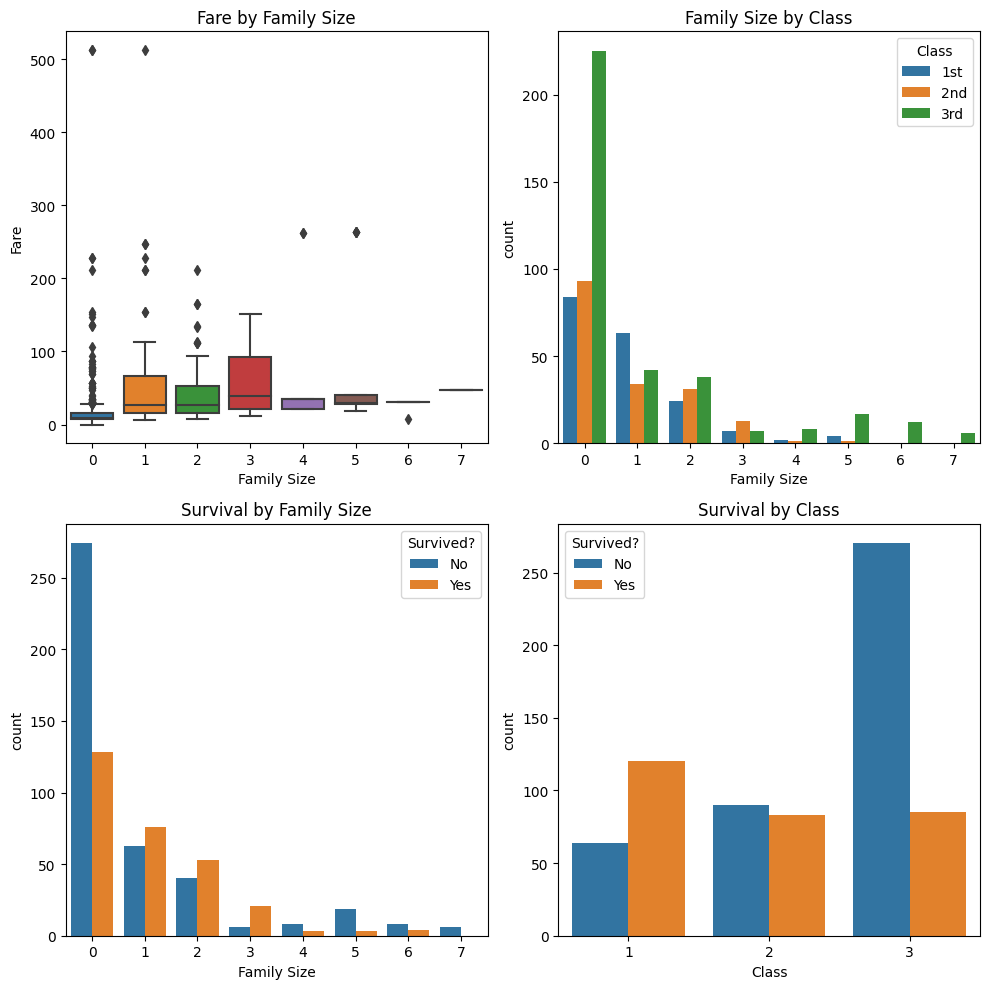

In [25]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(10, 10))

ax0.set_title('Fare by Family Size')
sns.boxplot(ax=ax0, data=df_titanic, x="Family_Size", y="Fare")
ax0.set_xlabel('Family Size')
ax0.set_ylabel('Fare')

ax1.set_title('Family Size by Class')
sns.countplot(ax=ax1, data=df_titanic, x="Family_Size", hue="Pclass")
ax1.set_xlabel('Family Size')
ax1.legend(class_labels, title='Class')

ax2.set_title('Survival by Family Size')
sns.countplot(ax=ax2, data=df_titanic, x="Family_Size", hue="Survived")
ax2.set_xlabel('Family Size')
ax2.legend(survived_labels, title='Survived?')

ax3.set_title('Survival by Class')
sns.countplot(ax=ax3, data=df_titanic, x="Pclass", hue="Survived")
ax3.set_xlabel('Class')
ax3.legend(survived_labels, title='Survived?')


## Dataset Splitting

In [26]:
X_train = df_titanic.drop('Survived',axis=1)
y_train = df_titanic.Survived

df_titanic_test = pd.read_csv('titanic/test.csv')
df_titanic_test_labels = pd.read_csv('titanic/gender_submission.csv')
df_titanic_test = df_titanic_test.merge(df_titanic_test_labels, on='PassengerId')

df_titanic_test = df_titanic_test.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
df_titanic_test = df_titanic_test[(df_titanic_test['Age'].notna())  & (df_titanic_test['Fare'].notna()) & (df_titanic_test['Embarked'].notna())]   
df_titanic_test['Sex'].replace(['male', 'female'], [1, 0], inplace=True)
df_titanic_test['Embarked'].replace(['C', 'Q', 'S'], [0, 1, 2], inplace=True)
df_titanic_test = df_titanic_test.reset_index(drop=True)
df_titanic_test['Deck'] = df_titanic_test['Cabin'].map(lambda x: x[0] if x is not np.nan else 'U')
df_titanic_test['Deck'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U'], [0, 1, 2, 3, 4, 5, 6, 7, 8], inplace=True)
df_titanic_test['Age_Group'] = df_titanic_test['Age'].map(lambda x: 0 if x < 18 else 1)
df_titanic_test = df_titanic_test.drop(['Cabin'], axis=1)
df_titanic_test['Family_Size']=df_titanic_test['SibSp'] + df_titanic_test['Parch']
df_titanic_test['Fare_Per_Person']=df_titanic_test['Fare'] / (df_titanic_test['Family_Size'] + 1)

X_test = df_titanic_test.drop('Survived',axis=1)
y_test = df_titanic_test.Survived

## Logistic Regression

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


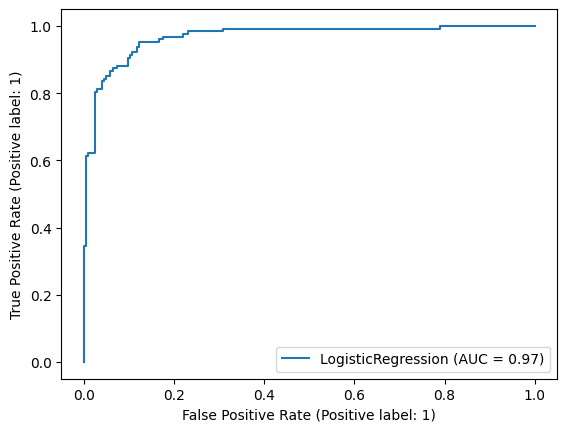

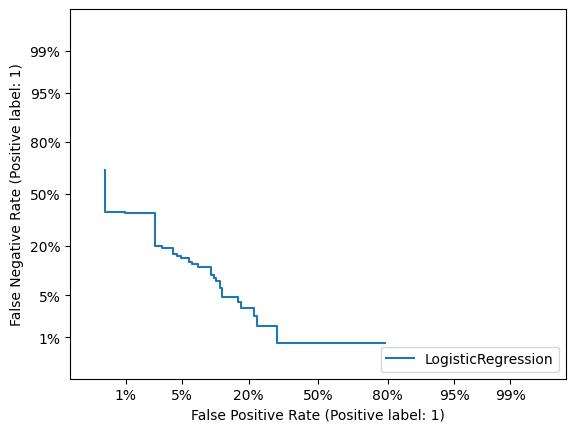

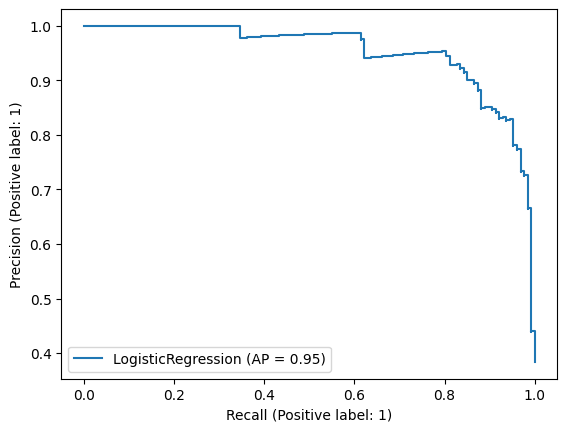

In [41]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
lr_acc = accuracy_score(y_test, y_pred)
lr_ratio = class_likelihood_ratios(y_test, y_pred)
lr_roc = RocCurveDisplay.from_estimator(model, X_test, y_test)
lr_det = DetCurveDisplay.from_estimator(model, X_test, y_test)
lr_pr = PrecisionRecallDisplay.from_estimator(model, X_test, y_test)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


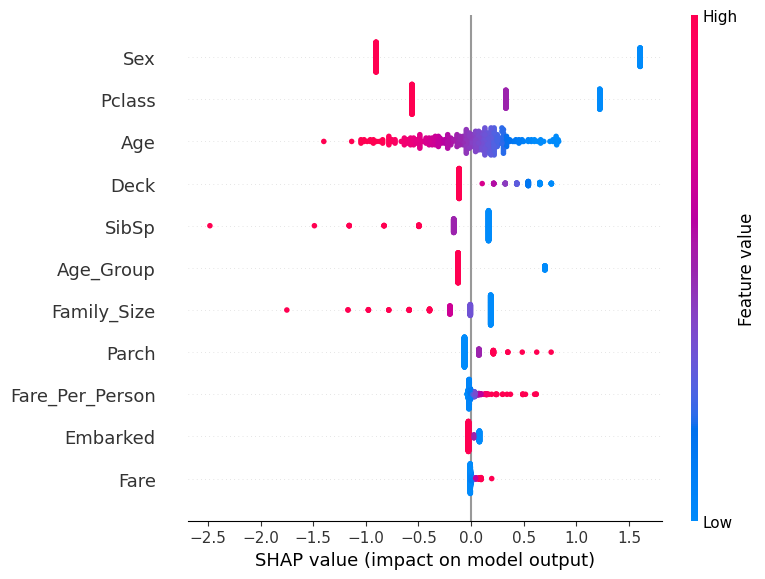

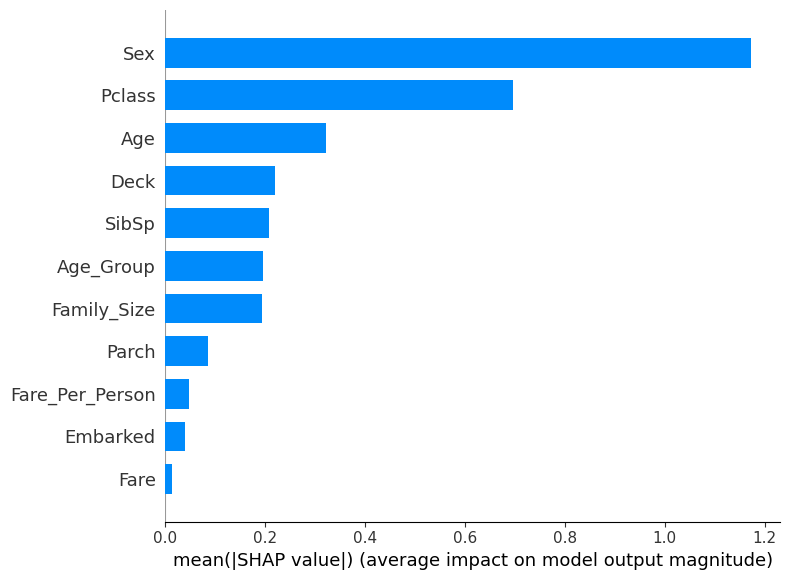

In [42]:
explainer = shap.LinearExplainer(model, X_train.astype(float), feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test.astype(float))
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_train, plot_type="bar")


## Decision Tree

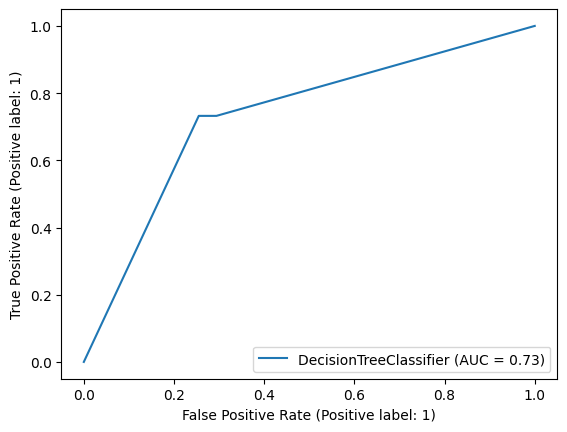

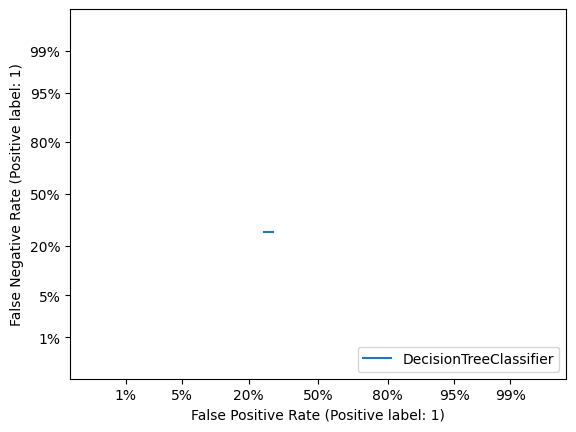

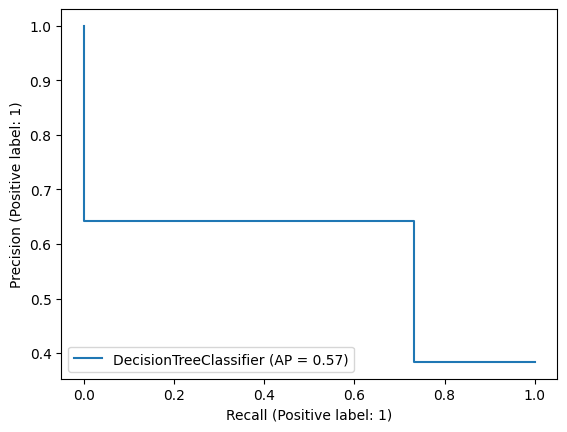

In [30]:
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
tree_acc = accuracy_score(y_test, y_pred)
tree_ratio = class_likelihood_ratios(y_test, y_pred)
tree_roc = RocCurveDisplay.from_estimator(model, X_test, y_test)
tree_det = DetCurveDisplay.from_estimator(model, X_test, y_test)
tree_pr = PrecisionRecallDisplay.from_estimator(model, X_test, y_test)

<BarContainer object of 11 artists>

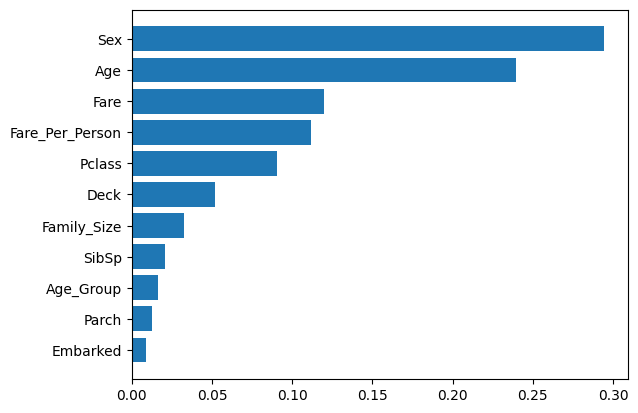

In [31]:
sorted_idx = model.feature_importances_.argsort()
features = X_train.columns
result = sorted(zip(features, model.feature_importances_), key = lambda x: x[1], reverse=False)
plt.barh([x[0] for x in result], [x[1] for x in result])

## Nearest Neighbours

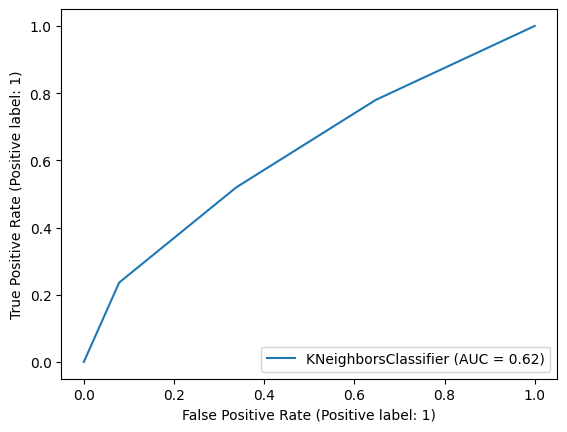

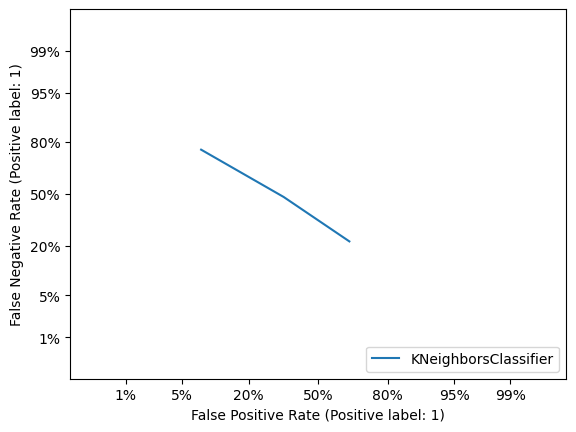

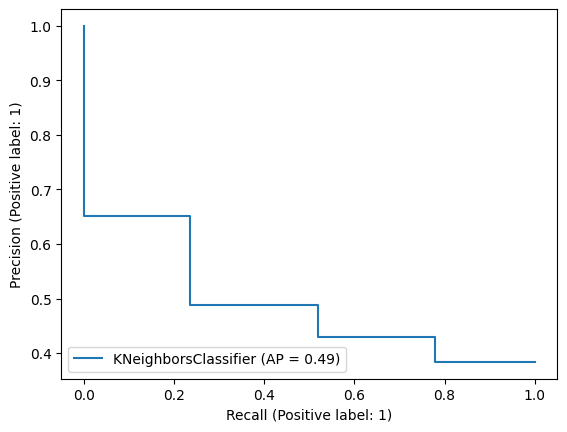

In [32]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
knn_acc = accuracy_score(y_test, y_pred)
knn_ratio = class_likelihood_ratios(y_test, y_pred)
knn_roc = RocCurveDisplay.from_estimator(model, X_test, y_test)
knn_det = DetCurveDisplay.from_estimator(model, X_test, y_test)
knn_pr = PrecisionRecallDisplay.from_estimator(model, X_test, y_test)

## Naive Bayes

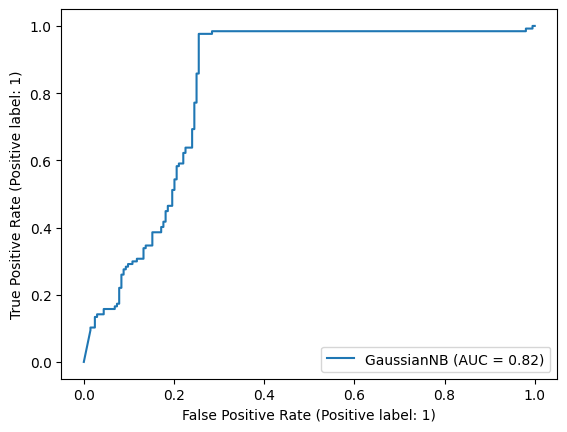

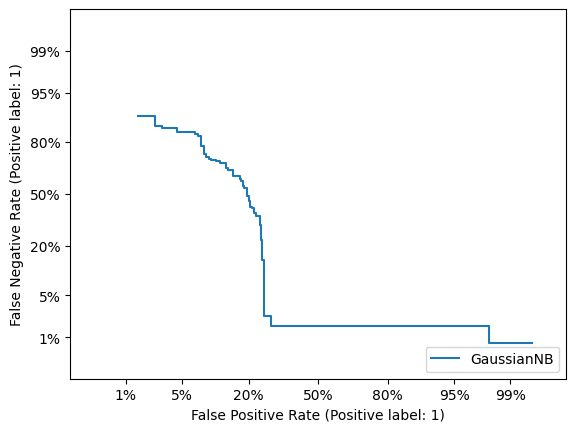

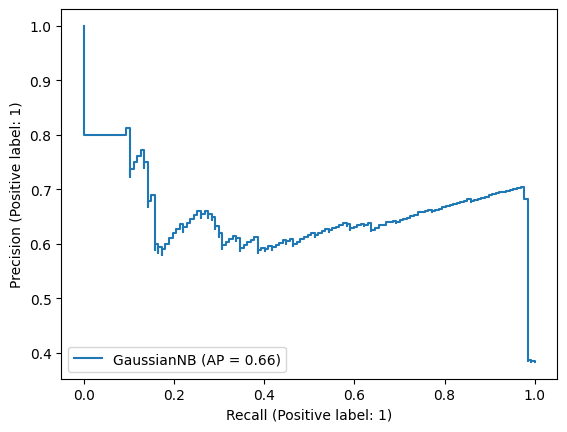

In [33]:
model = GaussianNB()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
nb_acc = accuracy_score(y_test, y_pred)
nb_ratio = class_likelihood_ratios(y_test, y_pred)
nb_roc = RocCurveDisplay.from_estimator(model, X_test, y_test)
nb_det = DetCurveDisplay.from_estimator(model, X_test, y_test)
nb_pr = PrecisionRecallDisplay.from_estimator(model, X_test, y_test)

## Support Vector Machine

Liblinear failed to converge, increase the number of iterations.


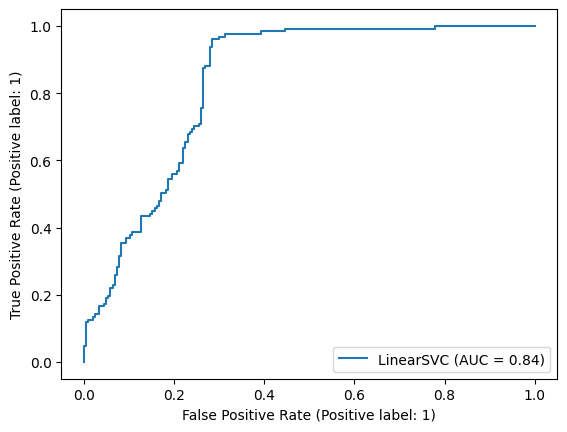

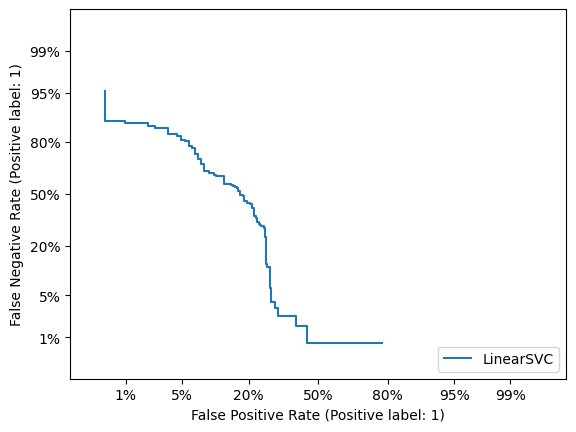

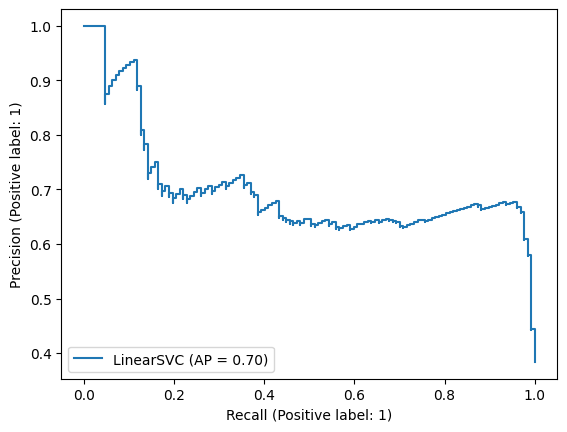

In [34]:
model = LinearSVC()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
svc_acc = accuracy_score(y_test, y_pred)
svc_ratio = class_likelihood_ratios(y_test, y_pred)
svc_roc = RocCurveDisplay.from_estimator(model, X_test, y_test)
svc_det = DetCurveDisplay.from_estimator(model, X_test, y_test)
svc_pr = PrecisionRecallDisplay.from_estimator(model, X_test, y_test)

## Neural Network

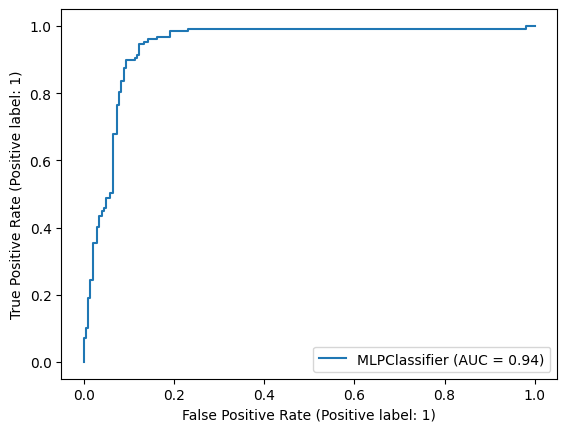

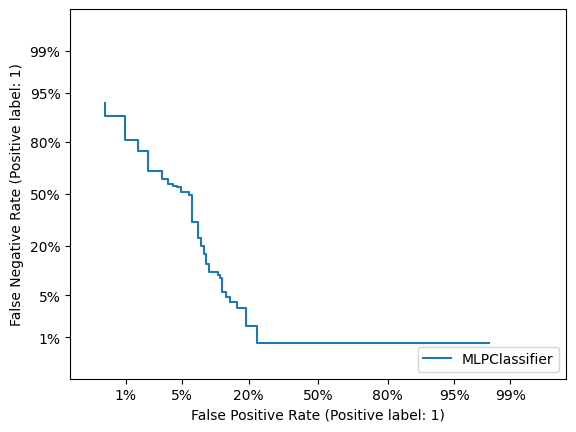

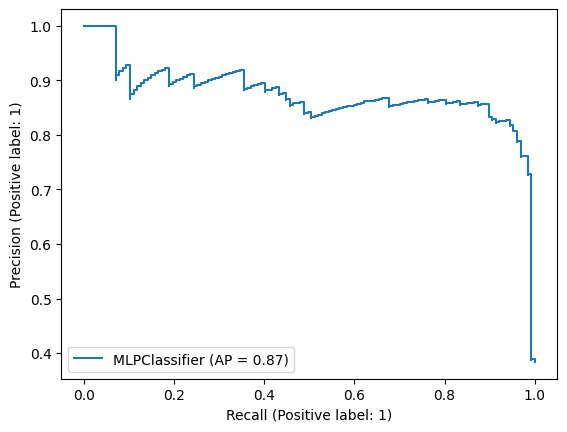

In [35]:
model = MLPClassifier()
model.fit(X_train, y_train)  
y_pred = model.predict(X_test)
mlp_acc = accuracy_score(y_test, y_pred)
mlp_ratio = class_likelihood_ratios(y_test, y_pred)
mlp_roc = RocCurveDisplay.from_estimator(model, X_test, y_test)
mlp_det = DetCurveDisplay.from_estimator(model, X_test, y_test)
mlp_pr = PrecisionRecallDisplay.from_estimator(model, X_test, y_test)

X does not have valid feature names, but MLPClassifier was fitted with feature names
Using 712 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/331 [00:00<?, ?it/s]X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
  0%|          | 1/331 [00:00<02:25,  2.27it/s]X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
  1%|          | 2/331 [00:00<02:22,  2.31it/s]X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
  1%|          | 3/331 [00:01<02:22,  2.30it/s]X does not have valid feature names, but MLPClassifier was 

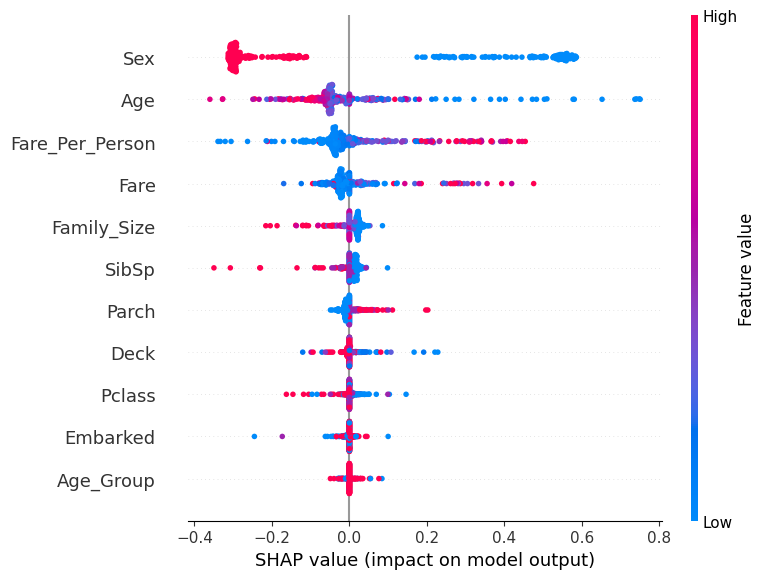

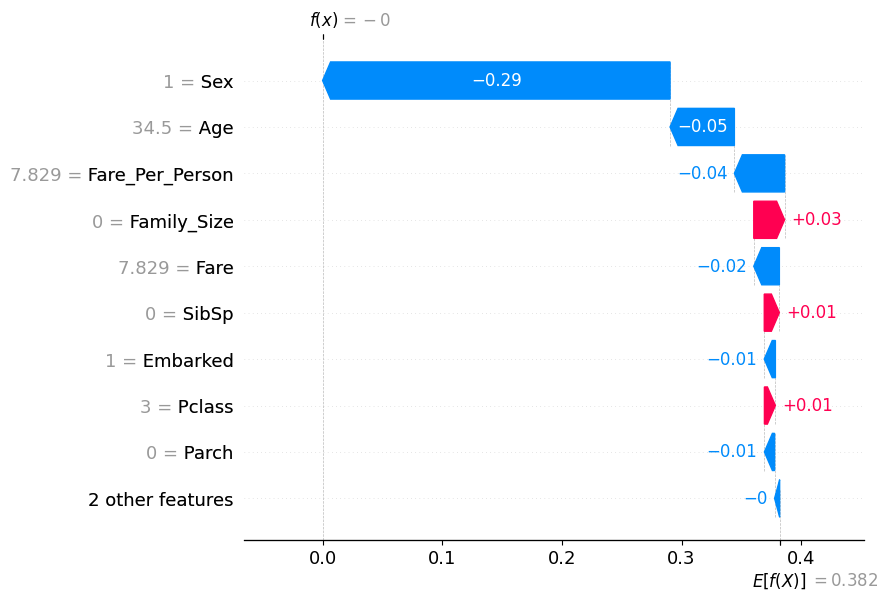

In [39]:
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test, nsamples=100)
shap.summary_plot(shap_values, X_test)

exp = Explanation(shap_values, explainer.expected_value, data=X_test.values, feature_names=X_test.columns)
shap.plots.waterfall(exp[0])

## Comparison Plots

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


Text(0.5, 0, 'Classifier')

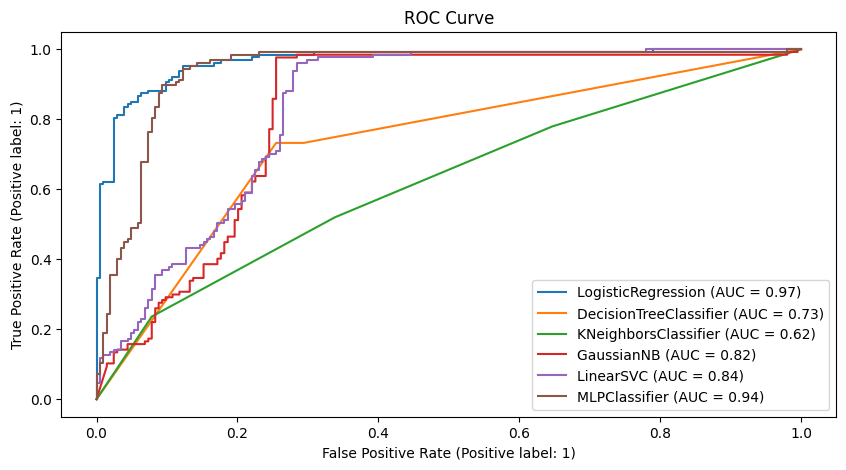

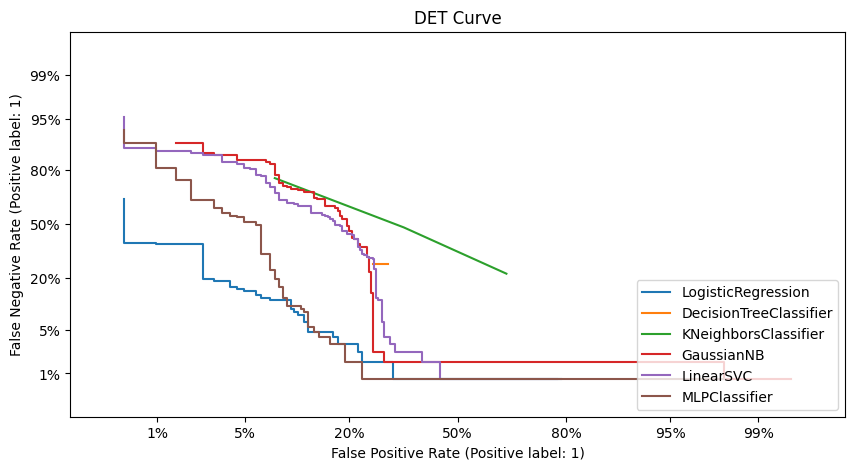

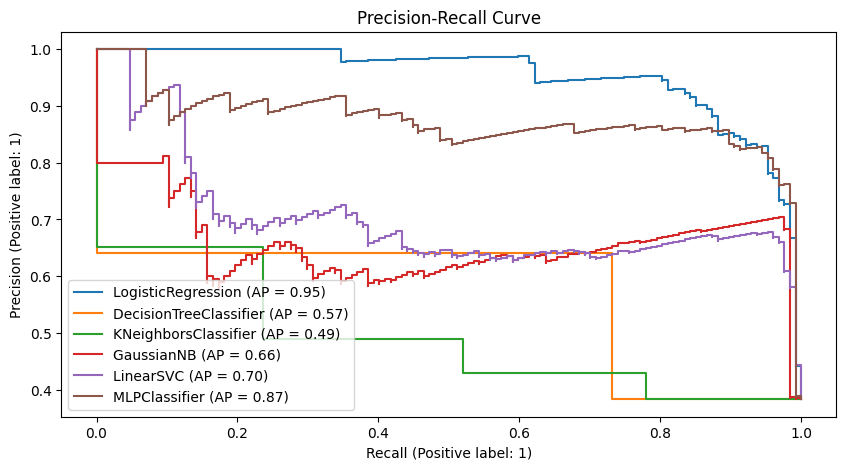

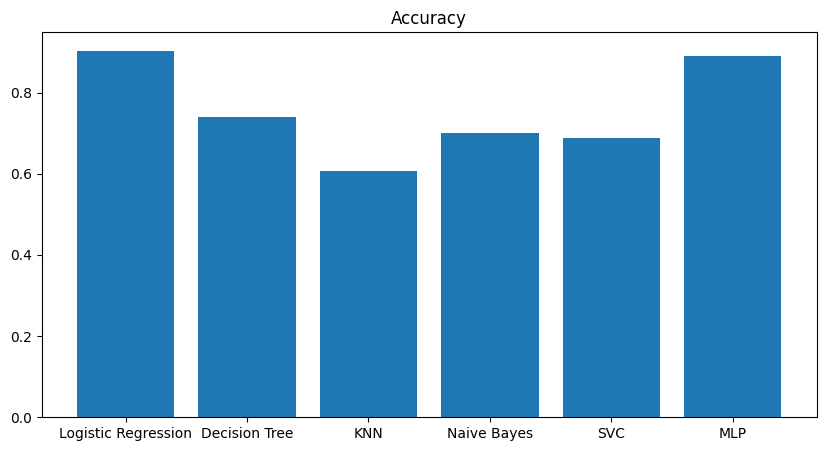

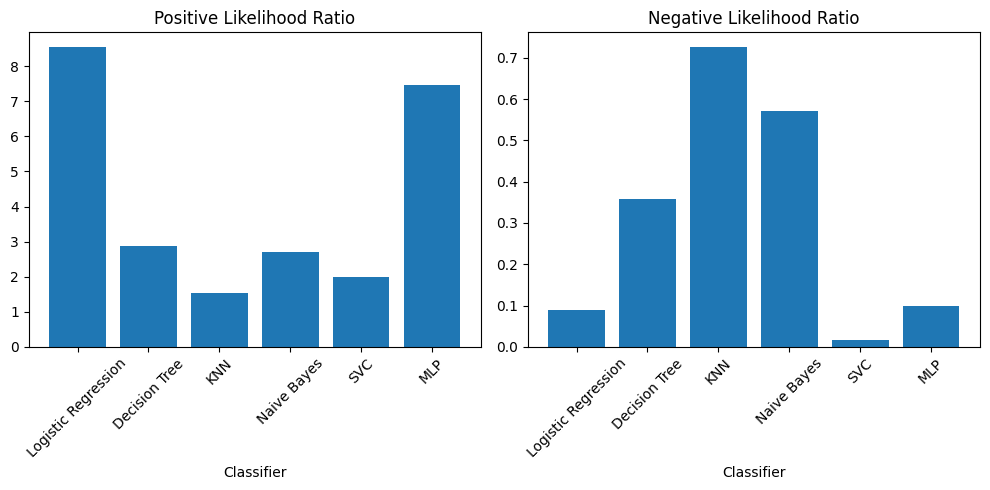

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('ROC Curve')
lr_roc.plot(ax=ax)
tree_roc.plot(ax=ax)
knn_roc.plot(ax=ax)
nb_roc.plot(ax=ax)
svc_roc.plot(ax=ax)
mlp_roc.plot(ax=ax)

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('DET Curve')
lr_det.plot(ax=ax)
tree_det.plot(ax=ax)
knn_det.plot(ax=ax)
nb_det.plot(ax=ax)
svc_det.plot(ax=ax)
mlp_det.plot(ax=ax)

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Precision-Recall Curve')
lr_pr.plot(ax=ax)
tree_pr.plot(ax=ax)
knn_pr.plot(ax=ax)
nb_pr.plot(ax=ax)
svc_pr.plot(ax=ax)
mlp_pr.plot(ax=ax)

model_labels = ['Logistic Regression', 'Decision Tree', 'KNN', 'Naive Bayes', 'SVC', 'MLP']

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Accuracy')
ax.bar(model_labels, [lr_acc, tree_acc, knn_acc, nb_acc, svc_acc, mlp_acc])
ax.set_xlabel('Classifier')

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, tight_layout=True,figsize=(10, 5))
ax0.set_title('Positive Likelihood Ratio')
ax0.bar(model_labels, [lr_ratio[0], tree_ratio[0], knn_ratio[0], nb_ratio[0], svc_ratio[0], mlp_ratio[0]])
ax0.set_xticklabels(labels=model_labels, rotation=45)
ax0.set_xlabel('Classifier')

ax1.set_title('Negative Likelihood Ratio')
ax1.bar(model_labels, [lr_ratio[1], tree_ratio[1], knn_ratio[1], nb_ratio[1], svc_ratio[1], mlp_ratio[1]])
ax1.set_xticklabels(labels=model_labels, rotation=45)
ax1.set_xlabel('Classifier')